# Imports

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 3.78 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
!pip install facenet-pytorch ninja lpips torchmetrics --force-reinstall --no-cache-dir
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 281.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 321.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 433.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 228.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 311.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 300.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 344.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 341.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 354.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 298.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

In [ ]:
import os

# Create a folder for models
os.makedirs('models', exist_ok=True)

# Download the stylegan2-ada-pytorch FFHQ model (resolution 1024x1024)
# This is hosted by NVIDIA
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O models/ffhq.pkl

print("Download complete.")

--2025-12-23 12:58:52--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 99.84.215.96, 99.84.215.15, 99.84.215.98, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|99.84.215.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘models/ffhq.pkl’

models/ffhq.pkl     100%[===================>] 363.94M   335MB/s    in 1.1s    

2025-12-23 12:58:55 (335 MB/s) - ‘models/ffhq.pkl’ saved [381624121/381624121]

Download complete.


In [ ]:
import torch
import pickle
import copy
import dnnlib
import legacy # From the cloned repo

import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from tqdm import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
import lpips
import math
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior (might slow down slightly)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(0)

In [ ]:
# load dictionary of {filename: embedding_vector}
with open("embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings.pkl'

In [ ]:
class StyleGANGenerator(torch.nn.Module):
    def __init__(self, network_pkl):
        super(StyleGANGenerator, self).__init__()
        print(f'Loading network from "{network_pkl}"...')

        with dnnlib.util.open_url(network_pkl) as f:
            # Load the network from the pickle file
            self.G = legacy.load_network_pkl(f)['G_ema'].to(device)

        # Lock the weights (we never train the generator itself)
        self.G.eval()
        for param in self.G.parameters():
            param.requires_grad = False

        # Store useful constants
        self.w_dim = self.G.w_dim  # Usually 512
        self.num_ws = self.G.mapping.num_ws # Usually 18 for 1024x1024
        print(f'Loaded network! (w_dim: {self.w_dim}, num_ws: {self.num_ws})')

    def forward(self, w_plus_vector):
        """
        Input: w_plus_vector of shape (Batch, 18, 512)
        Output: Image tensor (Batch, 3, 1024, 1024) in range [-1, 1]
        """
        # synthesis() expects input to be split by layers, but w+ is already shaped correctly
        # noise_mode='const' means we don't add random noise to hair/pores every time (deterministic)
        img = self.G.synthesis(w_plus_vector, noise_mode='const')
        return img

    def get_mean_w(self, n_samples=4096, seed=0):
        """
        Get the average latent code (W space).
        Optimizing starting from the Mean Face is much faster/easier.
        """
        torch.manual_seed(seed)
        z = torch.randn(n_samples, self.G.z_dim, device=device)
        w = self.G.mapping(z, None) # Convert z to w
        w_avg = w.mean(0, keepdim=True)

        return w_avg

# Initialize the model
generator = StyleGANGenerator('models/ffhq.pkl')
print("Generator Loaded Successfully!")

Loading network from "models/ffhq.pkl"...
Loaded network! (w_dim: 512, num_ws: 18)
Generator Loaded Successfully!


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


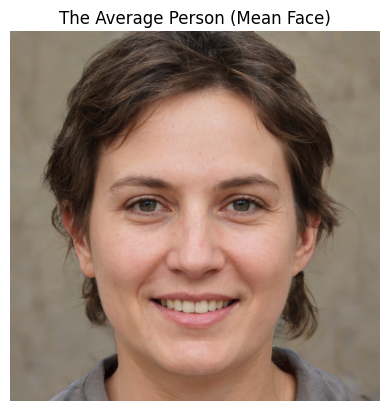

In [ ]:
# 1. Get the mean latent code
w_mean = generator.get_mean_w()

# 2. Generate the image
with torch.no_grad():
    generated_img_tensor = generator(w_mean)

# 3. Convert from [-1, 1] range to [0, 1] for visualization
# StyleGAN output is (B, 3, H, W)
vis_img = (generated_img_tensor.clamp(-1, 1) + 1) / 2.0
vis_img = vis_img[0].cpu() # Take first item in batch

# 4. Show it
plt.imshow(vis_img.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("The Average Person (Mean Face)")
plt.show()

In [ ]:
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor()
])

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
img_00001 = Image.open("00001.jpg").convert("RGB")
x_00001 = transform(img_00001).unsqueeze(0).to(device)
img_00002 = Image.open("00002.jpg").convert("RGB")
x_00002 = transform(img_00002).unsqueeze(0).to(device)

In [ ]:
emb_00001 = model(x_00001*2-1).detach().cpu()
emb_00002 = model(x_00002*2-1).detach().cpu()

In [ ]:
target_embedding = emb_00001.to(device)
target_image = x_00001

# General Functions

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()

        # Load VGG16
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

        # Slicing up to layer 16 (ReLU3_3) is standard.
        self.blocks = nn.Sequential(*list(vgg.children())[:16]).eval()

        # Freeze the model weights
        for param in self.blocks.parameters():
            param.requires_grad = False

        # VGG specific normalization
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
        self.resize = resize

    def forward(self, generated_img, target_img):
        # Assuming the images are in [0, 1] range:
        gen_norm = (generated_img - self.mean) / self.std
        target_norm = (target_img - self.mean) / self.std

        # Extract features
        gen_features = self.blocks(gen_norm)
        target_features = self.blocks(target_norm)

        # Calculate L2 loss between the feature maps
        loss = torch.nn.functional.mse_loss(gen_features, target_features)
        return loss

perceptual_criterion = VGGPerceptualLoss().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 92.7MB/s]


In [ ]:
def display_grid_graphs(metrics_dict, n_cols=2, steps_log=None, log_scale_keys=None, figsize=None):
    """
    Plots multiple graphs in a grid.

    Args:
        metrics_dict (dict): Dictionary where Key is the Title and Value is the list of data.
        n_cols (int): Number of columns in the grid.
        steps_log (list): list of step jumps. If None, include all the steps.
        log_scale_keys (list): List of keys from metrics_dict that should be plotted in log scale.
        figsize (tuple): Optional custom size (width, height). If None, calculates automatically.
    """
    if steps_log is None:
        steps_log = list(range(len(next(iter(metrics_dict.values())))))

    if log_scale_keys is None:
        log_scale_keys = []

    # Calculate Grid Dimensions
    n = len(metrics_dict)
    n_rows = math.ceil(n / n_cols)

    # Auto-calculate figure size if not provided
    if figsize is None:
        figsize = (4 * n_cols, 3 * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Plot Data
    for i, (label, values) in enumerate(metrics_dict.items()):
        ax = axes[i]
        ax.plot(steps_log, values)

        ax.set_title(f"{label} per Step")
        ax.set_xlabel("Step")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)

        if label in log_scale_keys:
            ax.set_yscale('log')

    # Hide empty subplots (if n is not a perfect multiple of n_cols)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def save_and_display_image(image, filename):
    image = image[0].permute(1, 2, 0).cpu().numpy()

    image_pil = transforms.ToPILImage()(image)
    image_pil.save(filename)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # display(final_image)

In [ ]:
lpips_metric = lpips.LPIPS(net='vgg').to(device)
# < 0.25 high similarity
# > 0.7 different images

psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
# > 30 dB: High quality (hard to distinguish difference).
# 20-30 dB: Acceptable quality.
# < 20 dB: Poor quality (very noisy).

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
# 1.0: Identical images.
# > 0.9: Very structurally similar.

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
def evaluate_and_log(i, iterations, current_img, target_img, history, freq=20, grayscale=False):
    """
    Evaluates metrics and updates history lists in-place.

    Args:
        i (int): Current iteration.
        iterations (int): Total iterations.
        current_img (Tensor): The normalized image (output of tanh, [-1, 1]).
        target_img (Tensor): The target image ([0, 1]).
        history (tuple): (lpips_list, psnr_list, ssim_list, steps).
        freq (int): Log frequency.
    """
    if i % freq != 0 and i != iterations - 1:
        return

    lpips_list, psnr_list, ssim_list, steps = history

    with torch.no_grad():
        # Convert [-1, 1] -> [0, 1]
        val_img = (current_img * 0.5) + 0.5
        tgt_img = target_img

        # Clamp to ensure numerical stability (fix float errors like -0.0001 or 1.0001)
        val_img = val_img.clamp(0, 1)
        tgt_img = tgt_img.clamp(0, 1)

        if grayscale:
            val_img = transforms.functional.rgb_to_grayscale(val_img, num_output_channels=3)
            tgt_img = transforms.functional.rgb_to_grayscale(tgt_img, num_output_channels=3)

        lpips_list.append(lpips_metric(val_img, tgt_img).item())
        psnr_list.append(psnr_metric(val_img, tgt_img).item())
        ssim_list.append(ssim_metric(val_img, tgt_img).item())
        steps.append(i)

# exp 11

### Setup

In [ ]:
experiment_name = "exp11_gmi_b"

iterations = 1000

w_avg = generator.get_mean_w()
latent_code = w_avg.clone().detach().to(device)
latent_code.requires_grad = True

optimizer = optim.Adam([latent_code], lr=0.05)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations)

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.002  # reg loss - deviation from average face

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

### Attack loop

In [ ]:
for i in tqdm(range(iterations)):
    optimizer.zero_grad()

    # Generate the image
    generated_image_1024 = generator(latent_code)

    # Resize for FaceNet (160x160)
    generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

    # Get Embedding
    current_embedding = model(generated_image_160)

    # Calculate loss
    loss_mse = mse_loss(current_embedding, target_embedding)
    # Penalize if the code gets too far from the average face (prevents "weird" artifacts)
    loss_reg = torch.mean((latent_code - w_avg) ** 2)
    # Total Loss
    total_loss = loss_mse + (reg_loss_weight * loss_reg)

    cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
    evaluate_and_log(i, iterations, generated_image_160, target_image, history_lists, freq=20)
    # perceptual_input = (generated_image_160 * 0.5) + 0.5
    # perceptual_with_real = perceptual_criterion(perceptual_input, target_image)

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if i == 0 or (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{iterations}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")

    loss_list.append(total_loss.item())
    cosine_similarity_list.append(cos_sim)
    # perceptual_list.append(perceptual_with_real.item())

final_image = generated_image_160.detach().cpu().squeeze(0)
final_embedding = current_embedding.detach().cpu().squeeze(0)
print("Inversion Complete.")

In [ ]:
display_grid_graphs({
    "Loss": loss_list,
    "Cosine Similarity": cosine_similarity_list
}, n_cols=3)

In [ ]:
display_grid_graphs({
    "LPIPS": lpips_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
}, n_cols=3, steps_log=steps)
print("""
    lpips_metric:
        < 0.25 high similarity
        > 0.7 different images

    psnr_metric:
        > 30 dB: High quality (hard to distinguish difference).
        20-30 dB: Acceptable quality.
        < 20 dB: Poor quality (very noisy).

    ssim_metric:
        1.0: Identical images.
        > 0.9: Very structurally similar.
""")

In [ ]:
with torch.no_grad():
    final_high_res = generator(latent_code)
    final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
    save_and_display_image(final_img, f"{experiment_name}.png")

In [ ]:
img_00000

In [ ]:
_lpips_list, _psnr_list, _ssim_list, _steps = [], [], [], []
_history_lists = (_lpips_list, _psnr_list, _ssim_list, _steps)

In [ ]:
evaluate_and_log(0, 1000, generated_image_160, target_image, _history_lists, freq=20, grayscale=False)
evaluate_and_log(0, 1000, generated_image_160, target_image, _history_lists, freq=20, grayscale=True)

In [ ]:
_history_lists

# exp 12 - decaying reg weight

### Setup

In [ ]:
experiment_name = "exp12_gmi_dacaying_reg_weight"

iterations = 1000

w_avg = generator.get_mean_w()
latent_code = w_avg.clone().detach().to(device)
latent_code.requires_grad = True

optimizer = optim.Adam([latent_code], lr=0.05)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations)

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.005  # reg loss - deviation from average face
reg_weight_start = 0.05
reg_weight_end = 0.0

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

### Attack loop

In [ ]:
for i in tqdm(range(iterations)):
    optimizer.zero_grad()

    # Generate the image
    generated_image_1024 = generator(latent_code)

    # Resize for FaceNet (160x160)
    generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

    # Get Embedding
    current_embedding = model(generated_image_160)

    # Calculate loss
    loss_mse = mse_loss(current_embedding, target_embedding)
    loss_reg = torch.mean((latent_code - w_avg) ** 2)

    current_weight = reg_weight_start + (reg_weight_end - reg_weight_start) * (i / iterations)

    # Total Loss
    total_loss = loss_mse + (current_weight * loss_reg)

    cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
    evaluate_and_log(i, iterations, generated_image_160, target_image, history_lists, freq=20)

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if i == 0 or (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{iterations}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")

    loss_list.append(total_loss.item())
    cosine_similarity_list.append(cos_sim)

final_image = generated_image_160.detach().cpu().squeeze(0)
final_embedding = current_embedding.detach().cpu().squeeze(0)
print("Inversion Complete.")

In [ ]:
display_grid_graphs({
    "Loss": loss_list,
    "Cosine Similarity": cosine_similarity_list
}, n_cols=3)

In [ ]:
display_grid_graphs({
    "LPIPS": lpips_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
}, n_cols=3, steps_log=steps)
print("""
    lpips_metric:
        < 0.25 high similarity
        > 0.7 different images

    psnr_metric:
        > 30 dB: High quality (hard to distinguish difference).
        20-30 dB: Acceptable quality.
        < 20 dB: Poor quality (very noisy).

    ssim_metric:
        1.0: Identical images.
        > 0.9: Very structurally similar.
""")

In [ ]:
with torch.no_grad():
    final_high_res = generator(latent_code)
    final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
    save_and_display_image(final_img, f"{experiment_name}.png")

In [ ]:
img_00000

# exp 13 - optimizing w instead of w+

### Setup

In [ ]:
experiment_name = "exp12_gmi_mahalanobis_dist"

iterations = 1000

w_avg = generator.get_mean_w()
w_single = w_avg[:, 0, :].clone().detach()
latent_code = w_single.to(device)
latent_code.requires_grad = True

optimizer = optim.Adam([latent_code], lr=0.05)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations)

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.005  # reg loss - deviation from average face
reg_weight_start = 0.05
reg_weight_end = 0.0

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

### Attack loop

In [ ]:
for i in tqdm(range(iterations)):
    optimizer.zero_grad()

    w_stack = latent_code.unsqueeze(1).repeat(1, 18, 1)

    # Generate the image
    generated_image_1024 = generator(w_stack)

    # Resize for FaceNet (160x160)
    generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

    # Get Embedding
    current_embedding = model(generated_image_160)

    # Calculate loss
    loss_mse = mse_loss(current_embedding, target_embedding)
    loss_reg = torch.mean((latent_code - w_single.to(device)) ** 2)

    current_weight = reg_weight_start + (reg_weight_end - reg_weight_start) * (i / iterations)

    # Total Loss
    total_loss = loss_mse + (current_weight * loss_reg)

    cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
    evaluate_and_log(i, iterations, generated_image_160, target_image, history_lists, freq=20)

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if i == 0 or (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{iterations}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")

    loss_list.append(total_loss.item())
    cosine_similarity_list.append(cos_sim)

final_image = generated_image_160.detach().cpu().squeeze(0)
final_embedding = current_embedding.detach().cpu().squeeze(0)
print("Inversion Complete.")

In [ ]:
display_grid_graphs({
    "Loss": loss_list,
    "Cosine Similarity": cosine_similarity_list
}, n_cols=3)

In [ ]:
display_grid_graphs({
    "LPIPS": lpips_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
}, n_cols=3, steps_log=steps)
print("""
    lpips_metric:
        < 0.25 high similarity
        > 0.7 different images

    psnr_metric:
        > 30 dB: High quality (hard to distinguish difference).
        20-30 dB: Acceptable quality.
        < 20 dB: Poor quality (very noisy).

    ssim_metric:
        1.0: Identical images.
        > 0.9: Very structurally similar.
""")

In [ ]:
with torch.no_grad():
    final_high_res = generator(w_stack)
    final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
    save_and_display_image(final_img, f"{experiment_name}.png")

In [ ]:
img_00001

# exp 14 - coarse to fine - w then w+

### Setup

In [ ]:
experiment_name = "exp14_gmi_coarse_to_fine"

iterations_1 = 25

w_avg = generator.get_mean_w(seed=15)
w_single = w_avg[:, 0, :].clone().detach()
latent_code = w_single.to(device)
latent_code.requires_grad = True

optimizer = optim.Adam([latent_code], lr=0.05)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations_1)

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.002  # reg loss - deviation from average face
# reg_weight_start = 0.05
# reg_weight_end = 0.0

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

images = []

### Attack loop

In [ ]:
for i in tqdm(range(iterations_1)):
    optimizer.zero_grad()

    w_stack = latent_code.unsqueeze(1).repeat(1, 18, 1)

    # Generate the image
    generated_image_1024 = generator(w_stack)

    # Resize for FaceNet (160x160)
    generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

    # Get Embedding
    current_embedding = model(generated_image_160)

    # Calculate loss
    loss_mse = mse_loss(current_embedding, target_embedding)
    loss_reg = torch.mean((latent_code - w_single.to(device)) ** 2)

    # Total Loss
    total_loss = loss_mse + (reg_loss_weight * loss_reg)

    cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
    evaluate_and_log(i, iterations_1, generated_image_160, target_image, history_lists, freq=20)

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if i == 0 or (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{iterations_1}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")
        img = (generated_image_160.detach() * 0.5) + 0.5
        images.append(img[0].permute(1, 2, 0).cpu().numpy())

    loss_list.append(total_loss.item())
    cosine_similarity_list.append(cos_sim)

iterations_2 = 1000
w_stack = latent_code.detach().unsqueeze(1).repeat(1, 18, 1)
w_plus = w_stack.clone()
w_plus.requires_grad = True
optimizer_w_plus = optim.Adam([w_plus], lr=0.0001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations_2)
reg_loss_weight = 0.002  # reg loss - deviation from average face

for i in tqdm(range(iterations_2)):
    optimizer_w_plus.zero_grad()

    # Generate the image
    generated_image_1024 = generator(w_plus)

    # Resize for FaceNet (160x160)
    generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

    # Get Embedding
    current_embedding = model(generated_image_160)

    # Calculate loss
    loss_mse = mse_loss(current_embedding, target_embedding)
    loss_reg = torch.mean((w_plus - w_avg) ** 2)

    # Total Loss
    total_loss = loss_mse + (reg_loss_weight * loss_reg)

    cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
    evaluate_and_log(i + iterations_1, iterations_2 + iterations_1, generated_image_160, target_image, history_lists, freq=20)

    total_loss.backward()
    optimizer_w_plus.step()
    scheduler.step()

    if i == 0 or (i + 1) % 100 == 0:
        print(f"Step [{i+1}/{iterations_2}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")
        img = (generated_image_160.detach() * 0.5) + 0.5
        images.append(img[0].permute(1, 2, 0).cpu().numpy())

    loss_list.append(total_loss.item())
    cosine_similarity_list.append(cos_sim)

final_image = generated_image_160.detach().cpu().squeeze(0)
final_embedding = current_embedding.detach().cpu().squeeze(0)
print("Inversion Complete.")

In [ ]:
display_grid_graphs({
    "Loss": loss_list,
    "Cosine Similarity": cosine_similarity_list
}, n_cols=3)

In [ ]:
display_grid_graphs({
    "LPIPS": lpips_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
}, n_cols=3, steps_log=steps)
print("""
    lpips_metric:
        < 0.25 high similarity
        > 0.7 different images

    psnr_metric:
        > 30 dB: High quality (hard to distinguish difference).
        20-30 dB: Acceptable quality.
        < 20 dB: Poor quality (very noisy).

    ssim_metric:
        1.0: Identical images.
        > 0.9: Very structurally similar.
""")

In [ ]:
with torch.no_grad():
    final_high_res = generator(w_stack)
    final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
    save_and_display_image(final_img, f"{experiment_name}.png")

In [ ]:

with torch.no_grad():
    final_high_res = generator(w_plus)
    final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
    save_and_display_image(final_img, f"{experiment_name}.png")

In [ ]:
img_00001

In [ ]:
for img in images:
    plt.imshow(img)
    plt.show()

# exp 15 - find best seed

### Setup

In [ ]:
experiment_name = "exp15_gmi_best_seed"

iterations_1 = 25

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.002  # reg loss - deviation from average face
# reg_weight_start = 0.05
# reg_weight_end = 0.0

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

images = []

### Attack loop

In [ ]:
w_stack_list = []
for seed in range(10, 35):
    print(f"Seed: {seed}")
    w_avg = generator.get_mean_w(seed=seed)
    w_single = w_avg[:, 0, :].clone().detach()
    latent_code = w_single.to(device)
    latent_code.requires_grad = True

    optimizer = optim.Adam([latent_code], lr=0.05)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations_1)

    for i in tqdm(range(iterations_1)):
        optimizer.zero_grad()

        w_stack = latent_code.unsqueeze(1).repeat(1, 18, 1)

        # Generate the image
        generated_image_1024 = generator(w_stack)

        # Resize for FaceNet (160x160)
        generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

        # Get Embedding
        current_embedding = model(generated_image_160)

        # Calculate loss
        loss_mse = mse_loss(current_embedding, target_embedding)
        loss_reg = torch.mean((latent_code - w_single.to(device)) ** 2)

        # Total Loss
        total_loss = loss_mse + (reg_loss_weight * loss_reg)

        cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
        evaluate_and_log(i, iterations_1, generated_image_160, target_image, history_lists, freq=20)

        total_loss.backward()
        optimizer.step()
        scheduler.step()

        if i == 0 or (i + 1) % 100 == 0:
            print(f"Step [{i+1}/{iterations_1}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")
            img = (generated_image_160.detach() * 0.5) + 0.5
            images.append(img[0].permute(1, 2, 0).cpu().numpy())

        loss_list.append(total_loss.item())
        cosine_similarity_list.append(cos_sim)

    w_stack_list.append((seed, w_stack))

Seed: 10


  8%|▊         | 2/25 [00:01<00:10,  2.15it/s]

Step [1/25], Loss: 0.003450


100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Seed: 11


  4%|▍         | 1/25 [00:00<00:03,  7.13it/s]

Step [1/25], Loss: 0.003410


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Seed: 12


  8%|▊         | 2/25 [00:00<00:04,  4.92it/s]

Step [1/25], Loss: 0.003512


100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Seed: 13


  4%|▍         | 1/25 [00:00<00:03,  7.18it/s]

Step [1/25], Loss: 0.003447


100%|██████████| 25/25 [00:03<00:00,  7.76it/s]


Seed: 14


  4%|▍         | 1/25 [00:00<00:03,  7.13it/s]

Step [1/25], Loss: 0.003486


100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


Seed: 15


  4%|▍         | 1/25 [00:00<00:03,  6.99it/s]

Step [1/25], Loss: 0.003424


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Seed: 16


  4%|▍         | 1/25 [00:00<00:03,  6.09it/s]

Step [1/25], Loss: 0.003457


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Seed: 17


  4%|▍         | 1/25 [00:00<00:03,  7.31it/s]

Step [1/25], Loss: 0.003425


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


Seed: 18


  4%|▍         | 1/25 [00:00<00:03,  7.11it/s]

Step [1/25], Loss: 0.003474


100%|██████████| 25/25 [00:03<00:00,  7.64it/s]


Seed: 19


  4%|▍         | 1/25 [00:00<00:03,  7.10it/s]

Step [1/25], Loss: 0.003437


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Seed: 20


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003386


100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Seed: 21


  4%|▍         | 1/25 [00:00<00:03,  7.08it/s]

Step [1/25], Loss: 0.003399


100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


Seed: 22


  4%|▍         | 1/25 [00:00<00:03,  7.19it/s]

Step [1/25], Loss: 0.003527


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Seed: 23


  4%|▍         | 1/25 [00:00<00:03,  6.18it/s]

Step [1/25], Loss: 0.003482


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Seed: 24


  4%|▍         | 1/25 [00:00<00:03,  7.01it/s]

Step [1/25], Loss: 0.003377


100%|██████████| 25/25 [00:03<00:00,  7.77it/s]


Seed: 25


  4%|▍         | 1/25 [00:00<00:03,  7.20it/s]

Step [1/25], Loss: 0.003514


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


Seed: 26


  4%|▍         | 1/25 [00:00<00:03,  7.18it/s]

Step [1/25], Loss: 0.003458


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Seed: 27


  4%|▍         | 1/25 [00:00<00:03,  7.03it/s]

Step [1/25], Loss: 0.003463


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


Seed: 28


  8%|▊         | 2/25 [00:00<00:06,  3.46it/s]

Step [1/25], Loss: 0.003421


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Seed: 29


  4%|▍         | 1/25 [00:00<00:03,  7.07it/s]

Step [1/25], Loss: 0.003475


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Seed: 30


  4%|▍         | 1/25 [00:00<00:03,  6.18it/s]

Step [1/25], Loss: 0.003505


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Seed: 31


  4%|▍         | 1/25 [00:00<00:03,  7.10it/s]

Step [1/25], Loss: 0.003379


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Seed: 32


  4%|▍         | 1/25 [00:00<00:03,  6.71it/s]

Step [1/25], Loss: 0.003458


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Seed: 33


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003508


100%|██████████| 25/25 [00:03<00:00,  7.65it/s]


Seed: 34


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003457


100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


In [ ]:
img_00001

# exp 16 - average seeds

### Setup

In [ ]:
experiment_name = "exp16_gmi_average_seeds"

iterations_1 = 25

mse_loss = torch.nn.MSELoss()
reg_loss_weight = 0.002  # reg loss - deviation from average face
# reg_weight_start = 0.05
# reg_weight_end = 0.0

loss_list = []
cosine_similarity_list = []
lpips_list = []
psnr_list = []
ssim_list = []
steps = []
history_lists = (lpips_list, psnr_list, ssim_list, steps)

images = []

### Attack loop

In [ ]:
w_stack_list = []
for seed in range(10, 35):
    print(f"Seed: {seed}")
    w_avg = generator.get_mean_w(seed=seed)
    w_single = w_avg[:, 0, :].clone().detach()
    latent_code = w_single.to(device)
    latent_code.requires_grad = True

    optimizer = optim.Adam([latent_code], lr=0.05)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=iterations_1)

    for i in tqdm(range(iterations_1)):
        optimizer.zero_grad()

        w_stack = latent_code.unsqueeze(1).repeat(1, 18, 1)

        # Generate the image
        generated_image_1024 = generator(w_stack)

        # Resize for FaceNet (160x160)
        generated_image_160 = F.interpolate(generated_image_1024, size=(160, 160), mode='bilinear', align_corners=False)

        # Get Embedding
        current_embedding = model(generated_image_160)

        # Calculate loss
        loss_mse = mse_loss(current_embedding, target_embedding)
        loss_reg = torch.mean((latent_code - w_single.to(device)) ** 2)

        # Total Loss
        total_loss = loss_mse + (reg_loss_weight * loss_reg)

        cos_sim = nn.functional.cosine_similarity(current_embedding, target_embedding).item()
        evaluate_and_log(i, iterations_1, generated_image_160, target_image, history_lists, freq=20)

        total_loss.backward()
        optimizer.step()
        scheduler.step()

        if i == 0 or (i + 1) % 100 == 0:
            print(f"Step [{i+1}/{iterations_1}], Loss: {total_loss.item():.6f}")#, Perc: {perceptual_with_real.item():.6f}")
            img = (generated_image_160.detach() * 0.5) + 0.5
            images.append(img[0].permute(1, 2, 0).cpu().numpy())

        loss_list.append(total_loss.item())
        cosine_similarity_list.append(cos_sim)

    w_stack_list.append(w_stack)

Seed: 10


  8%|▊         | 2/25 [00:01<00:10,  2.15it/s]

Step [1/25], Loss: 0.003450


100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Seed: 11


  4%|▍         | 1/25 [00:00<00:03,  7.13it/s]

Step [1/25], Loss: 0.003410


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Seed: 12


  8%|▊         | 2/25 [00:00<00:04,  4.92it/s]

Step [1/25], Loss: 0.003512


100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Seed: 13


  4%|▍         | 1/25 [00:00<00:03,  7.18it/s]

Step [1/25], Loss: 0.003447


100%|██████████| 25/25 [00:03<00:00,  7.76it/s]


Seed: 14


  4%|▍         | 1/25 [00:00<00:03,  7.13it/s]

Step [1/25], Loss: 0.003486


100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


Seed: 15


  4%|▍         | 1/25 [00:00<00:03,  6.99it/s]

Step [1/25], Loss: 0.003424


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Seed: 16


  4%|▍         | 1/25 [00:00<00:03,  6.09it/s]

Step [1/25], Loss: 0.003457


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Seed: 17


  4%|▍         | 1/25 [00:00<00:03,  7.31it/s]

Step [1/25], Loss: 0.003425


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


Seed: 18


  4%|▍         | 1/25 [00:00<00:03,  7.11it/s]

Step [1/25], Loss: 0.003474


100%|██████████| 25/25 [00:03<00:00,  7.64it/s]


Seed: 19


  4%|▍         | 1/25 [00:00<00:03,  7.10it/s]

Step [1/25], Loss: 0.003437


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Seed: 20


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003386


100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Seed: 21


  4%|▍         | 1/25 [00:00<00:03,  7.08it/s]

Step [1/25], Loss: 0.003399


100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


Seed: 22


  4%|▍         | 1/25 [00:00<00:03,  7.19it/s]

Step [1/25], Loss: 0.003527


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Seed: 23


  4%|▍         | 1/25 [00:00<00:03,  6.18it/s]

Step [1/25], Loss: 0.003482


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Seed: 24


  4%|▍         | 1/25 [00:00<00:03,  7.01it/s]

Step [1/25], Loss: 0.003377


100%|██████████| 25/25 [00:03<00:00,  7.77it/s]


Seed: 25


  4%|▍         | 1/25 [00:00<00:03,  7.20it/s]

Step [1/25], Loss: 0.003514


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


Seed: 26


  4%|▍         | 1/25 [00:00<00:03,  7.18it/s]

Step [1/25], Loss: 0.003458


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Seed: 27


  4%|▍         | 1/25 [00:00<00:03,  7.03it/s]

Step [1/25], Loss: 0.003463


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


Seed: 28


  8%|▊         | 2/25 [00:00<00:06,  3.46it/s]

Step [1/25], Loss: 0.003421


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Seed: 29


  4%|▍         | 1/25 [00:00<00:03,  7.07it/s]

Step [1/25], Loss: 0.003475


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Seed: 30


  4%|▍         | 1/25 [00:00<00:03,  6.18it/s]

Step [1/25], Loss: 0.003505


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Seed: 31


  4%|▍         | 1/25 [00:00<00:03,  7.10it/s]

Step [1/25], Loss: 0.003379


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Seed: 32


  4%|▍         | 1/25 [00:00<00:03,  6.71it/s]

Step [1/25], Loss: 0.003458


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Seed: 33


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003508


100%|██████████| 25/25 [00:03<00:00,  7.65it/s]


Seed: 34


  4%|▍         | 1/25 [00:00<00:03,  7.09it/s]

Step [1/25], Loss: 0.003457


100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


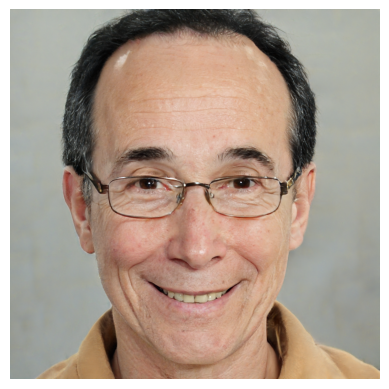

In [ ]:
with torch.no_grad():
  average_tensor = torch.stack(w_stack_list).mean(dim=0)
  final_high_res = generator(average_tensor)
  final_img = (final_high_res.clamp(-1, 1) + 1) / 2.0
  save_and_display_image(final_img, f"average_w.jpg")

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # MUST be run before importing deepface

import cv2
from deepface import DeepFace

# Load images
img1 = cv2.imread("00001.jpg")
img2 = cv2.imread("average_w.jpg")

# Run Verification
try:
    result = DeepFace.verify(
        img1,
        img2,
        model_name="ArcFace",
        enforce_detection=False,
        detector_backend='skip' # Bypasses the detector that might be changing the shape
    )
    print(f"Verified: {result['verified']}")
    print(f"Distance: {result['distance']}")
except Exception as e:
    print(f"Error: {e}")

Verified: True
Distance: 0.648438
